# Basic optical ray tracing, faster
Francis Deck, 1-6-2023

See **readme.md** for general explanatory information, such as why I did this.

This is my first version using **numpy** and **sympy**. Some of the operations are still a bit kludgy, will continue to improve.

I'm finding that it's important to track the shape of numpy arrays through the calculations to understand what's going on. Comments like

    # [scalar]
    # vector
    # [point]
    
are meant to indicate the structure of the thing being computed. For now, I'm going to follow this convention: The ray table will be a numpy array, but surfaces will still be represented by a list of **dict** objects. The reason is that the computational time of ray tracing is $O(n_{surfaces}*n_{rays})$ whereas retrieving surface data is just $O(n_{surfaces})$. All of the rays are computed at each surface, using array operations. For now, optimization efforts should focus on rays. 

The surface table is not homogeneous, because different surfaces may have different properties, and doesn't lend itself to vectorizing. Also, it needs to be more readable, because you'll be working on designs more than on ray tracing code.

**Testing**: Set **run_tests = True** and do "Kernel --> Restart and Run All"

**Use as a library**: Set **run_tests = False**. Install Python library **import_ipynb** and you can import this notebook from a notebook or Python program.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import sympy as sp
print('raytrace imported', datetime.datetime.now())

run_tests = True # set false if you're going to import this into another notebook

raytrace imported 2023-02-26 10:07:58.413564


## Math needs
**Numpy** generally works OK at making vectorized math readable in Python, except when it doesn't. Cases where **numpy** barfs on an expression typically have to do with true ambiguities about how to interpret it, requiring you to be more specific about array shapes, but by extension, more verbose. To wit: If you try to multiply a 2-d array by a 1-d array, for instance, **numpy** doesn't know what you mean, and just matching the lengths of axes exposes you to bugs caused by those lengths being equal by accident. (For instance tracing 3 rays and multiplying by a length-3 array). You have to specify how to align the axes, and what shape of output you want. Two particular pitfalls:

**Dot products**: The **np.sum()** function sums over all of the elements of an array of any shape and returns a scalar. We often need to turn a column of vectors into a column of scalar dot products. This is done by adding an "axis" qualifier to the **np.sum()** function, for instance:

    np.sum(v, axis = 1) # v: [vectors]
    
In general, a vector or point is a triple. The distinction is purely for readability. Points are referenced to the global coordinate system, vectors are relative

    v: np.array([vx, vy, vz])
    
**Array of scalars and array of vectors in an expression**: The mismatch of shapes causes **numpy** to generate an error message. The work-around is to add an **np.newaxis** to the smaller array, such as in the **normalize()** function below.
    
Multiplying an array of vectors by an array of scalars causes an error, but the **np.newaxis()** function reshapes the smaller array to accept the shape of the bigger one.

**Multiplying an array of scalars and a single vector to produce an array of vectors**. I'm using **np.outer()** for this purpose. It seems to be the right tool for the job.

Overall, you should try to use built-in **numpy** functions, while avoiding loops whenever possible. That's because **numpy** runs in tight compiled code, whereas loops run in slow Python.

In [19]:
def norm(x):
    '''
    length of vector
    '''
    if len(x.shape) == 1:
        # x: vector
        return np.sqrt(np.sum(x*x)) # scalar
    else:
        # x: [vectors]
        return np.sqrt(np.sum(x*x, axis=1)) # [scalars]
    
def normalize(v):
    '''
    return a vector of same direction but unit length
    '''
    if len(v.shape) == 1:
        # v: vector
        return v / norm(v) # vector
    else:
        # v: [vectors]
        return v / norm(v)[:, np.newaxis] # [vectors]

The sag function $z(r)$ for a conic section surface will be entered symbolically, so its derivative can be computed automatically. Note as a minor trick, that I will actually compute $\dfrac 1 r \dfrac {\partial z}{\partial r}$ because I will actually want it in that form, and eliminating a factor of $r$ here avoids a divide-by-zero later for the case where $r=0$. I suspect a further simplification is possible by turning $\sqrt{1 - c^2r^2(k+1)}$ into its own symbol.

On the other hand, since I'm *actually* most interested in plain spherical and parabolic surfaces it might make sense to break those out into separate surface types. Ultimately, it makes sense to include a "custom" sag function unique to each surface, in the surface itself. My testing of these ideas will be based on measuring rays per second for a moderately complex model.

In [20]:
r, c, k = sp.symbols('r c k')

sag_conic_sp = c*r**2/(1 + sp.sqrt(1 - (1 + k)*c**2*r**2))
sag_conic_sp

c*r**2/(sqrt(-c**2*r**2*(k + 1) + 1) + 1)

In [21]:
sag_conic_diff_sp = sp.simplify(sp.diff(sag_conic_sp, r)/r)
sag_conic_diff_sp

c*(c**2*r**2*(k + 1) + 2*sqrt(-c**2*r**2*(k + 1) + 1)*(sqrt(-c**2*r**2*(k + 1) + 1) + 1))/(sqrt(-c**2*r**2*(k + 1) + 1)*(sqrt(-c**2*r**2*(k + 1) + 1) + 1)**2)

In [22]:
# **sp.lambdify** converts the function back into a regular Python function, using
# portions of **numpy**.

sag_conic = sp.lambdify([r, c, k], sag_conic_sp, 'numpy')
sag_conic_diff = sp.lambdify([r, c, k], sag_conic_diff_sp, 'numpy')

### Distance from a point to a line

https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line

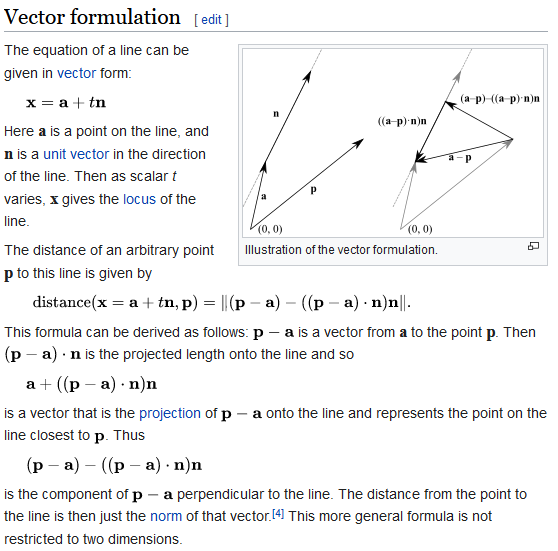

In [23]:
def distance_point_line(a, n, p):
    """
    distance from point to line
    a = point on the line
    n = unit vector in direction of line
    p = point in space
    """
    if len(p.shape) == 1:
        # p: point
        return norm(p - a - n*np.dot(p - a, n))
    else:
        # p: [point]
        return norm(p - a - np.outer(np.sum((p - a)*n, axis = 1), n))

### Intersection of a line and a plane

https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection

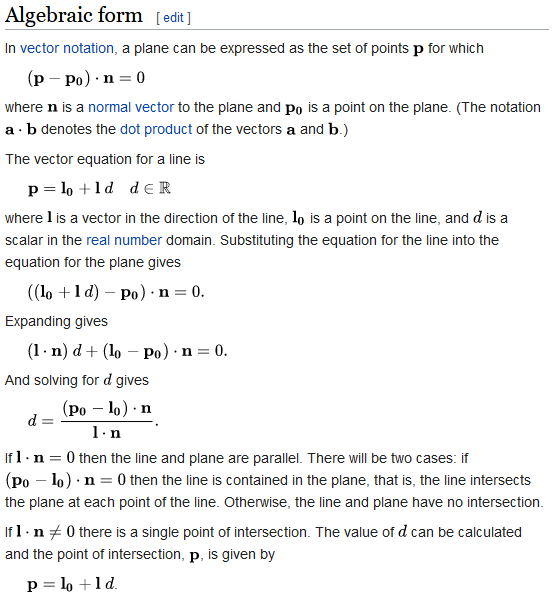

In [24]:
def intersect_line_plane(x_surf, n_surf, x_line, v_line):
    """
    intersection of line and plane
    x_surf = point on plane
    n_surf = normal to plane
    x_line = point on line
    v_line = direction vector of line
    """
    if len(x_line.shape) == 1:
        # x_line: point
        return x_line + v_line * np.dot((x_surf - x_line), n_surf) / np.dot(v_line, n_surf)
    else:
        # x_line: [points]
        nps = (np.sum((x_surf-x_line)*n_surf, axis=1) / np.sum(v_line*n_surf, axis=1))[:, np.newaxis] 
        return x_line + v_line * nps

### Coordinate transformations

https://www.haroldserrano.com/blog/rotations-in-computer-graphics

In [25]:
def rotate_matrix(axis, alpha_deg):
    '''
    generic rotation matrix
    '''
    alpha = alpha_deg * np.pi / 180
    a, b, c = axis
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    K = 1 - ca
    return np.matrix(
        [
            [a**2 * K + ca,       a * b * K - c * sa,  a * c * K + b * sa],
            [a * b * K + c * sa,  b**2 * K + ca,       b * c * K - a * sa],
            [a * c * K - b * sa,  b * c * K + a * sa,  c**2 * K + ca],
        ]
    )


def coord_rotate(v, axis, alpha_deg):
    '''
    coordinate rotation of a vector around an axis and angle
    v: vector or point = The thing to be rotated
    axis: vector = The rotation axis
    alpha:deg = Amount of rotation in degrees
    '''
    M = rotate_matrix(axis, alpha_deg)
    return np.array(np.matmul(M, v))[0, :]


def coord_shift(x, dx):
    '''
    coordinate shift of a vector by a distance vector
    Will probably get rid of, self explanatory
    '''
    return x + dx

## Surfaces representation
    
We're going to start with surfaces. Currently, the following types are supported:

    {'surf': 'conic', 'c': curvature, 'k': conic_constant, 'n1': n1, 'n2': n2, 'dist': distance, ...}
    {'surf': 'dummy', 'dist': distance, ...}
    {'surf': 'shift', 'axis': vector, ...}
    {'surf': 'rotate', 'delta': vector, 'degrees': angle, ...}
    {'surf': 'plane grating', 'groove_width': w, 'wavelength': wl, 'dist': distance, ...}
    
These are the parameters that you specify for your model. A set of local coordinates will be added to each surface by the **build_geometry()** function. Also, the ellipses suggest that more parameters will be added, but I've included only those that are essential for understanding the math. The distance **dist** is the distance to the *next* surface along the local z-axis of each surface.

Surfaces will be combined to form a surface_list:

    surface_list: [surface, surface, ...]
    
Once the geometry has been built, each surface gains three new properties:

    geometry: {...'origin': point, 'x_axis': uvector, 'y_axis': uvector, 'z_axis: uvector ...}
    
This is a coordinate basis local to the surface, allowing plane and symmetrical surfaces to be defined with relatively few parameters. The local coordinates also guide the drawing of the surfaces.

**Units of measure**: Note that there are none. Everything is scalable to any unit system, so long as you're consistent. I'm going to be using mm. The only catch so far is that wavelengths are specified in mm, so a 633 nm laser is given as 633e-6

**build_geometry()** doesn't have to be fast because it runs once when you start a model.

In [26]:
def apply_geometry_defaults(d, defaults):
    return d | {k: defaults[k] for k in defaults if k not in d}

def build_geometry(surface_list):
    geometry_defaults = {"dist": 0,
                         "draw_radius": 10, "draw_dx": 0, "draw_dy": 0}
    
    # This is the coordinate basis that will be cumulatively updated
    # at each surface
    origin = np.array((0, 0, 0))
    x_axis = np.array((1, 0, 0))
    y_axis = np.array((0, 1, 0))
    z_axis = np.array((0, 0, 1))

    # Run through the surfaces, applying the coordinate basis to each
    # surface, while updating it for use by the next surface.
    geometry = []
    for s in surface_list:
        g = apply_geometry_defaults(s, geometry_defaults)
        if g["surf"] == "rotate":
            x_axis = coord_rotate(x_axis, g["axis"], g["degrees"])
            y_axis = coord_rotate(y_axis, g["axis"], g["degrees"])
            z_axis = coord_rotate(z_axis, g["axis"], g["degrees"])
        elif g["surf"] == "shift":
            origin = coord_shift(
                origin,
                g["delta"][0] * x_axis
                + g["delta"][1] * y_axis
                + g["delta"][2] * z_axis,
            )
        # Apply the new coordinates to the current surface
        g["origin"] = np.array(origin)
        g["x_axis"] = np.array(x_axis)
        g["y_axis"] = np.array(y_axis)
        g["z_axis"] = np.array(z_axis)
        # Set the origin of the next surface
        origin = origin + g["dist"] * z_axis
        geometry.append(g)
        
    return geometry

## Representing the rays

The bare necessities for a ray are an intersection point $\vec x$ and direction vector $\vec v$. To aid in computation, I've built a *ray table*, with the following structure:

    ray_table: [surface number, ray number, type, point or vector]
    
    surface number: Identifies the surface that the ray intersects
    ray number: Identifies a unique ray traced through the surfaces
    type: 0 for x, and 1 for v
    point or vector: either x or v
    
For instance:

    ray_table[2, :, 0, :]
    
represents the positions of all of the rays passing through surface 2. The purpose of this apparent complexity is that the ray table is a homogeneous array, and thus can be sliced and diced by **numpy**. The trick to making Python fast for number crunching is to keep the ball in **numpy**'s court whenever possible. This is **numpy** programming, but is readable as Python code.

For now I'm keeping all other ray properties, suc as wavelength, out of the ray table. Those are going into a dictionary of arrays.

## Propagation of ray to dummy surface

Dummy surface is a plane defined by the origin of the surface, and its z-axis.

In [27]:
def propagate_dummy_surface(ray_table, en, ex, surface):
    # Acts on all of the rays at a surface at once
    # en = ray number of previous surface (entrance)
    # ex = ray number of this surface (exit)
    ray_table[ex, :, 0, :] = intersect_line_plane(surface["origin"], surface["z_axis"],
                                                 ray_table[en, :, 0, :], ray_table[en, :, 1, :])
    ray_table[ex, :, 1, :] = ray_table[en, :, 1, :]

## Propagation of rays through refractive surface

I don't know who wrote this derivation, I found the image in a Google search, and it checks out.

https://image.slidesharecdn.com/raytracing-111026083006-phpapp01/95/ray-tracing-23-728.jpg

A second source at least is of known origin:

https://web.cse.ohio-state.edu/~shen.94/681/Site/Main.html

The slides on reflection and refraction are at: 

https://web.cse.ohio-state.edu/~shen.94/681/Site/Slides_files/reflection_refraction.pdf

**Step 1** Find the intersection of the entrance ray with the curved surface. I'm using the "standard" conic section sag equation (look up anywhere):

$z(r) = \dfrac {c r^2} {1 + \sqrt{1 - (1 + k)c^2r^2}}$

$r$ = distance from z axis

$c$ = curvature, i.e., reciprocal of radius-of-curvature

$k$ = conic constant, zero for sphere, -1 for parabola

Finding this intersection is an interative process:

1. Compute r and sag, trace ray to plane $z$ = sag
2. Re-compute r and sag, trace ray to new $z$ = sag
3. For now, good enough to just repeat this 10 times

**Step 2**: Compute a unit vector normal to the surface. For a rotationally symmetric function of $r^2$,

$\dfrac {\partial z(x, y)} {\partial x} = \dfrac {\partial z(r^2)}{\partial r^2} \dfrac {\partial r^2} {\partial x} =   2x\dfrac {\partial z(r^2)}{\partial r^2}$ ,likewise for $y$.

I computed $\dfrac {\partial z(r^2)}{\partial r^2}$ using wxMaxima. Later on I'd like to do this within the notebook using SymPy.

Here's the wxMaxima code for generating the derivative. WxMaxima doesn't produce Python output, but Fortran is easy enough to translate by hand:

    sag: c*R2/(1 + sqrt(1 - (1+k)*c^2*R2));
	fortran(diff(sag,R2,1));
    
**Step 3**: Compute the exit vector using one of the equations from the above references:

$\vec v_{ex} = (-\eta \vec n \cdot \vec v_{en} - \sqrt {1 - \eta^2(1-(\vec n \cdot \vec v{_en})^2})
\vec n + \eta v_{en}$

where $\eta = n_{en}/n_{ex}$. For mirrors, the traditional trick is to let $\eta = -1$ by specifying $n_{ex} = -n_{en}$, and reversing the z-axis rather than having a second equation for mirrors.

In [28]:
def propagate_conic_surface(ray_table, en, ex, surface):
    # first step is intersecting the input ray with the curved surface
    sag = np.zeros([ray_table.shape[1]])
    for k in range(10):
        ray_table[ex, :, 0, :] = intersect_line_plane(
            surface["origin"] + np.outer(sag, surface["z_axis"]), surface["z_axis"],
            ray_table[en, :, 0, :], ray_table[en, :, 1, :])
        r = distance_point_line(
            surface["origin"],
            surface["z_axis"],
            ray_table[ex, :, 0, :])
        sag = sag_conic(r, surface["c"], surface["k"])

    # second step is finding surface normal on the exit surface
    sd = sag_conic_diff(r, surface['c'], surface['k'])
    #d_sag_d_r2(r, surface["c"], surface["k"])
    x = np.dot(ray_table[ex, :, 0, :] - surface["origin"], surface["x_axis"])
    y = np.dot(ray_table[ex, :, 0, :] - surface["origin"], surface["y_axis"])

    #n = normalize(  # array of vectors
    #    np.outer(2*x*sd, surface["x_axis"])
    #    + np.outer(2*y*sd, surface["y_axis"])
    #    - surface["z_axis"])
    
    n = normalize(np.outer(sd*x, surface['x_axis'])
                 + np.outer(sd*y, surface['y_axis'])
                 - surface['z_axis'])

    # third step is finding the direction of the refracted ray
    i = -ray_table[en, :, 1, :]  # [vectors]
    ci = np.sum(i*n, axis=1) # [scalars]
    eta = surface["n1"] / surface["n2"]  # scalar
    ct = np.sqrt(1 - eta**2 * (1 - ci**2))  # [scalars]
    vr = (eta * ci - ct)[:, np.newaxis]*n - eta*i # [vectors]
    ray_table[ex, :, 1, :] = vr

## Propagation of rays through diffraction grating

Grating. Equation 6.7 from here:

https://www.phys.uconn.edu/~eyler/phys4150/R/OSLO%20Optics%20Reference.pdf

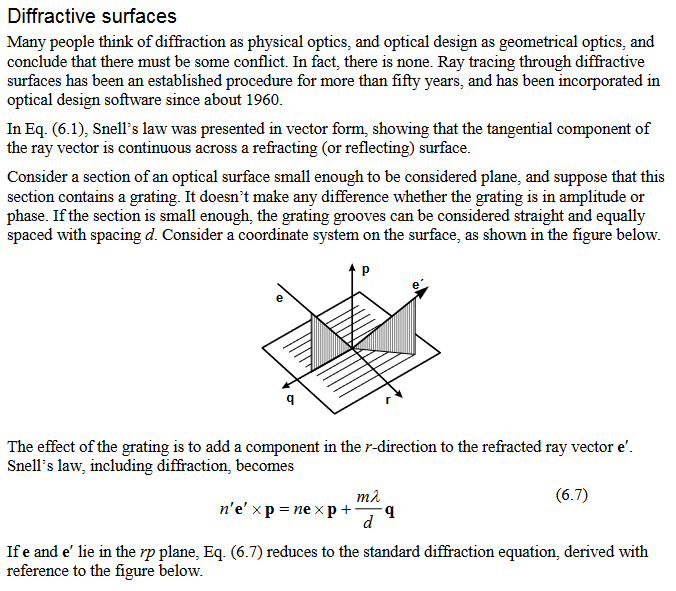

The grating equation as shown is completely general:

$n' \hat e' \times \hat p = n \hat e \times p + \dfrac {m \lambda} {d} \hat q$

However, for a plane grating, normal to the optical axis, and with grooves parallel to the x axis, it can be simplified by letting $\hat p = \hat k$ and $\hat q = \hat i$

Using the traditional formula for the cross product:

$\vec{a} \times \vec{b} = (a_2b_3-a_3b_2)i + (a_3b_1-a_1b_3)j+(a_1b_2-a_2b_1)k$

The general grating equation reduces to:

$n'(e'_y \hat x + e'_x \hat y) = n (e_y \hat x + e_x \hat y) + \dfrac {m \lambda} d \hat x$

Collecting like terms,

$e'_y = \dfrac 1 {n'}(n e_y + \dfrac {m \lambda)} d)$

$e'_x = \dfrac n {n'} e_x$

The simplification is acceptable because any other orientation of the grating can be handled with coordinate breaks. It avoids the need to solve a system of 3 equations to find the exit vector, at the expense of generality.

As for concave gratings, my experience is that they are un-modelable. The reason is that concave holographic gratings tend to be quite specialized, and often have non-parallel grooves due to aberration corrections applied during the writing of the hologram. And the makers of these gratings can be reluctant to share their model data.

In [29]:
def propagate_plane_grating(ray_table, en, ex, surface, ray_properties):
    # en, ex are entrance and exit surface numbers, typically en = ex - 1
    
    ray_table[ex, :, 0, :] = intersect_line_plane(
            surface["origin"], surface["z_axis"],
            ray_table[en, :, 0, :], ray_table[en, :, 1, :])
    
    # three arrays of scalars in coordinates local to the surface
    
    exy = (
        surface["n1"] * np.dot(ray_table[en, :, 1, :], surface["y_axis"])
        + surface["m"] * ray_properties['wavl'] / surface["d"]
    ) / surface["n2"]
    
    exx = surface["n1"] * np.dot(ray_table[en, :, 1, :],
                                surface["x_axis"]) / surface["n2"]
                                
    exz = np.sqrt(1 - exx*exx - exy*exy)
    
    # convert to a vector in global coordinates
    
    ray_table[ex, :, 1, :] = (np.outer(exx, surface["x_axis"]) 
        + np.outer(exy, surface["y_axis"])
        + np.outer(exz, surface["z_axis"]))

## Propagating rays through rotate and shift
*Nothing happens* to the rays through rotate and shift operations because rays are already expressed in global coordinates. Rotate and shift can be thought of as moving the optical system underneath the rays.

## Ray propagation through all surfaces
This function brings together all of the surface types under one roof, and builds a ray list -- a list of rays that propagate through the design, guided by the surface list.

It is necessarily an iterative process. The starting ray should typically be in the x-y plane, thus it represents an object point and direction vector. Based on the type of surface, a new ray is formed and appended to the list. However, the conic surface is special. The ray approaching a conic surface doesn't "know" the intersection point yet, so it doesn't know its destination, but has arrived at the x-y plane of the new surface. A *new ray* is computed that is extended to the intersection point, and this is what's appended to the ray list. This is why **propagate_conic** returns two rays -- a modified version of its incident ray, and a refracted ray.

All other surfaces (for now at least) are planar and don't need this treatment.

The last surface doesn't propagate rays any further. It only exists to be drawn.

In [30]:
def propagate_ray(ray_table, ray_properties, geometry):
    # No tracing to first surface
    for i in range(1, len(geometry)):
        g = geometry[i]
        if g["surf"] in ["rotate", "shift", "dummy"]:
            propagate_dummy_surface(ray_table, i-1, i, g)
        elif g["surf"] == "conic":
            propagate_conic_surface(ray_table, i-1, i, g)
        elif g["surf"] == "plane grating":
            propagate_plane_grating(ray_table, i-1, i, g, ray_properties)
        else:
            print("Did not recognize surface type", g["surf"])

## Basic graphing
Remember, this isn't Zemax. The purpose of graphing is to aid in testing the programs by visualizing the output. I'm going to use them to check that my programs are functioning with no glaring errors.

If you want zoom-able graphs add **%matplotlib notebook** after importing **pyplot**. You may have to restart the kernel if you make this change. Notebook mode will gradually eat up your processing time because each graph spawns a Javascript process.

In [31]:
def new_plot_xy(axes=["x", "y"], **kwargs):
    # axes is an optional list of axes that you actually want to plot
    fig, axs = plt.subplots(len(axes), 1, sharex="col", sharey="row", **kwargs)
    # resolve fact that plt.subplots returns either a scalar axs or a list
    # depending on number of axes. We want always a list for consistency
    # later on.
    if len(axes) == 1:
        return {"fig": fig, "axs": [axs]} | {axes[i]: i for i in range(len(axes))}
    else:
        return {"fig": fig, "axs": axs} | {axes[i]: i for i in range(len(axes))}


def plot_faces(axd, surface_list):
    npts = 50
    x = np.empty((npts, 3))

    for s in surface_list:
        ra = np.linspace(-s["draw_radius"], s["draw_radius"], npts)
        xa = ra + s["draw_dx"]
        ya = ra + s["draw_dy"]

        # generate drawing curves in local coordinates of object
        match s["surf"]:
            case ("dummy" | "plane_grating" | "rotate" | "shift"):
                zxa = np.zeros_like(ra)
                zya = zxa
            case "conic":
                zxa = sag_conic(xa, s["c"], s["k"])
                zya = sag_conic(ya, s["c"], s["k"])

        # first graph shows the z-x coordinate axis in global space
        if "x" in axd:
            for i in range(npts):
                x[i, :] = s["origin"] + xa[i] * \
                    s["x_axis"] + zxa[i] * s["z_axis"]
            axd["axs"][axd["x"]].plot(x[:, 2], x[:, 0], linewidth=1)
            axd["axs"][axd["x"]].set_ylabel("X (mm)")

        # second graph shows the z-y coordinate axis in global space
        if "y" in axd:
            for i in range(npts):
                x[i, :] = s["origin"] + ya[i] * \
                    s["y_axis"] + zya[i] * s["z_axis"]
            axd["axs"][axd["y"]].plot(x[:, 2], x[:, 1], linewidth=1)
            axd["axs"][axd["y"]].set_ylabel("Y (mm)")
        axd["axs"][-1].set_xlabel("Z (mm)")

    [ax.set_aspect("equal") for ax in axd["axs"]]


def print_ray_table(ray_table):
    print('surface ray x y z vx vy vz')
    for s in range(ray_table.shape[0]):
        for r in range(ray_table.shape[1]):
            print(s, r, ray_table[s, r, 0, :], ray_table[s, r, 1, :])


def ray_table_from_fields_vectors(geometry, field_points, vectors):
    ray_table = np.empty([len(geometry), len(field_points)*len(vectors), 2, 3])
    for i in range(len(field_points)):
        for j in range(len(vectors)):
            k = j + i*len(vectors)
            ray_table[0, k, 0, :] = field_points[i]
            ray_table[0, k, 1, :] = vectors[j]
    return ray_table


def ray_table_from_fields_points(geometry, field_points, pupil_points):
    ray_table = np.empty(
        [len(geometry), len(field_points)*len(pupil_points), 2, 3])
    for i in range(len(field_points)):
        for j in range(len(pupil_points)):
            k = j + i*len(pupil_points)
            ray_table[0, k, 0, :] = field_points[i]
            ray_table[0, k, 1, :] = normalize(
                pupil_points[j] - field_points[i])
    return ray_table

In [32]:
def plot_rays(axd, geometry, ray_table, ray_properties, **kwargs):
    keep = [s['draw_radius'] != 0 for s in geometry]

    for i in range(ray_table.shape[1]):
        if "x" in axd:
            axd["axs"][axd["x"]].plot(
                ray_table[:, i, 0, 2][keep], ray_table[:, i, 0, 0][keep], **kwargs)
        if "y" in axd:
            axd["axs"][axd["y"]].plot(
                ray_table[:, i, 0, 2][keep], ray_table[:, i, 0, 1][keep], **kwargs)

In [33]:
def default_ray_properties(ray_table):
    return {'wavl': np.full((ray_table.shape[1]), 633e-6)}

## Design process for now

I plan on adding some "helper" functions for things that prove to be repetitive in the tests. Meanwhile, the design process looks like what you see in **test2()**:
1. Build the surface list. Remember, this is Python, so you can pre-compute some parameters, then use those parameters to define the surfaces if you want.
2. Build the geometry using **build_geometry()**, which adds coordinates to the surfaces and fills in some defaults.
3. You have to figure out how to define field and pupil points. I plan on improving that process.
4. For now I've got some helper functions to turn the lists of field and pupil points into the ray table.
5. Also, generate a list of properties for the ray table, using the defaults if desired.
6. Use **propagate_rays()** to trace the rays through the geometry. This is where the bulk of ray tracing math is occurring.
7. Graphing and analysis. These are primitive for now.

## Testing

### Single ray through basic lens

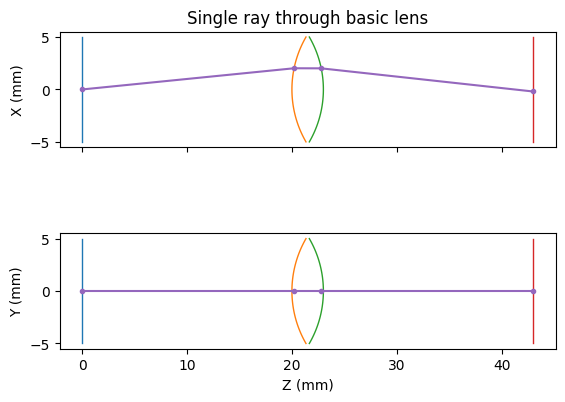

In [34]:
def test1():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 10, "draw_radius": 5}
    ]
    geometry = build_geometry(surface_list)
    field_points = np.array([[0, 0, 0]])
    pupil_points = np.array([[1, 0, 10]])
    ray_table = ray_table_from_fields_points(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.')
    axd["axs"][0].set_title("Single ray through basic lens")

if run_tests: test1()

### Singlet lens, finite conjugate

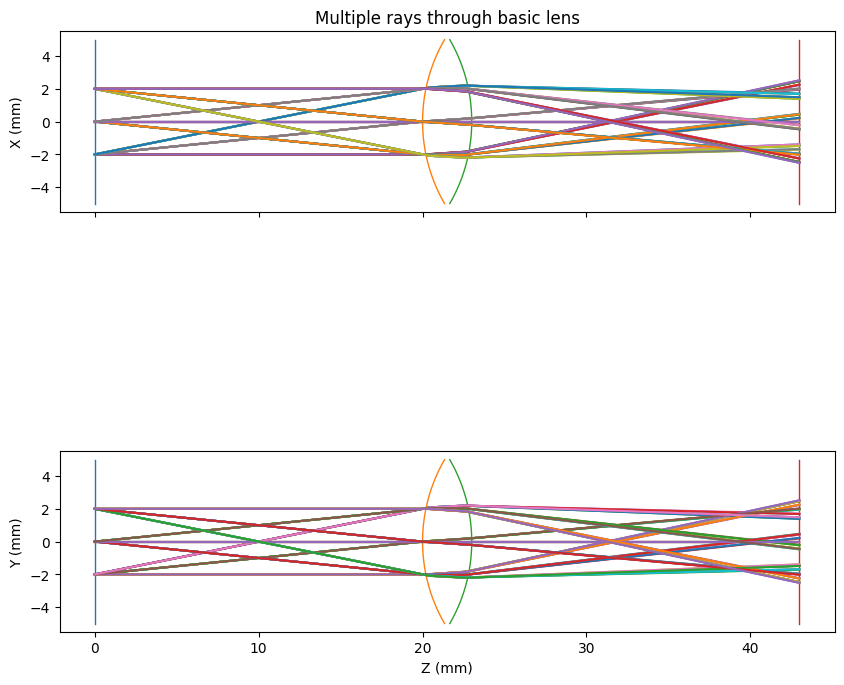

In [35]:
def test2():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-2, 2, 3)
    lsp = np.linspace(-2, 2, 3)
    fieldPoints = np.array([[x, y, 0] for x in lsf for y in lsf])
    pupilPoints = np.array([[x, y, 20] for x in lsp for y in lsp])
    
    ray_table = ray_table_from_fields_points(geometry, fieldPoints, pupilPoints)
    
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties)
    axd["axs"][0].set_title("Multiple rays through basic lens")

if run_tests: test2()

This is from *certain optics software*:
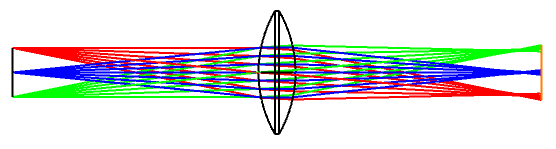

### Singlet lens, infinite conjugate

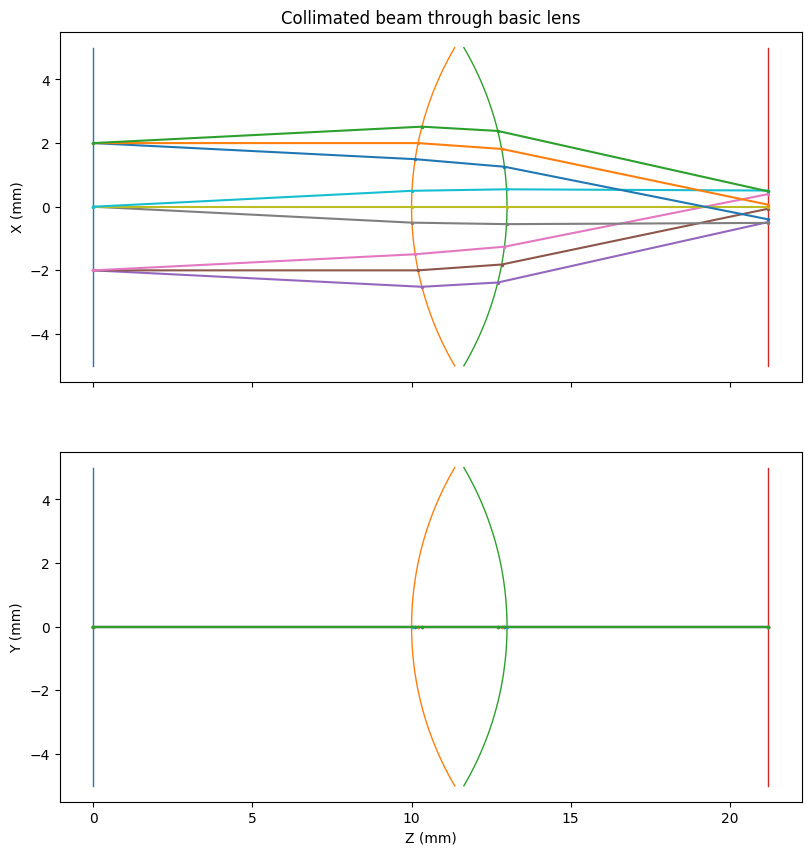

In [36]:
def test3():
    surface_list = [
        {"surf": "dummy", "dist": 10, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3.0,
            "c": 1 / 9.9,
            "k": 0,
            "n1": 1,
            "n2": 1.515,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 8.2,
            "c": -1 / 9.9,
            "k": 0,
            "n1": 1.515,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-2, 2, 3)
    lsp = np.linspace(-0.05, 0.05, 3)
    field_points = np.array([np.array([x, 0, 0]) for x in lsf])
    pupil_points = np.array([normalize(np.array([x, 0, 1])) for x in lsp])
    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Collimated beam through basic lens")

if run_tests: test3()

### Spherical mirror

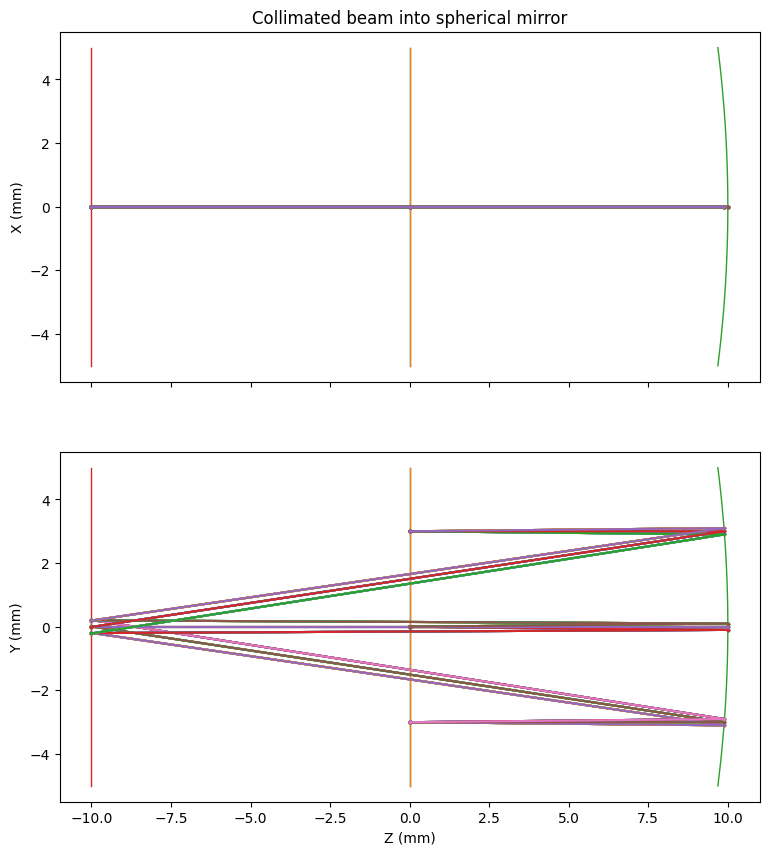

In [37]:
def test4():
    surface_list = [
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
        {"surf": "dummy", "dist": 10, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 40,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-3, 3, 3)
    lsp = np.linspace(-0.01, 0.01, 3)
    
    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Collimated beam into spherical mirror")

if run_tests: test4()

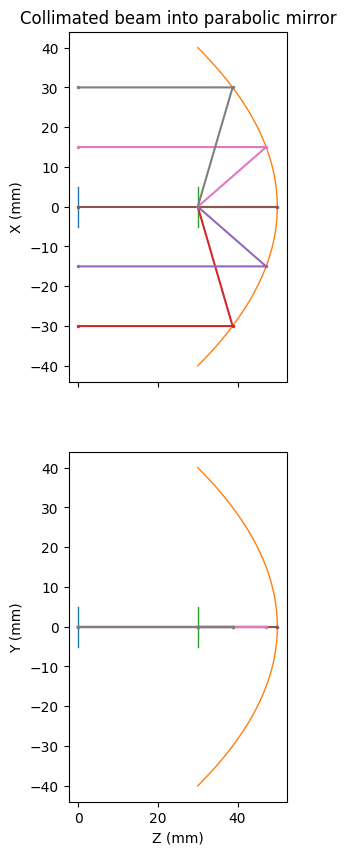

In [38]:
def test5():
    surface_list = [
        {"surf": "dummy", "dist": 50, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 40,
            "k": -1,
            "n1": 1,
            "n2": -1,
            "draw_radius": 40,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-30, 30, 5)

    field_points = [np.array([x, 0, 0]) for x in lsf]
    pupil_points = np.array([[0, 0, 1]])

    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Collimated beam into parabolic mirror")

if run_tests: test5()

### Diffraction grating

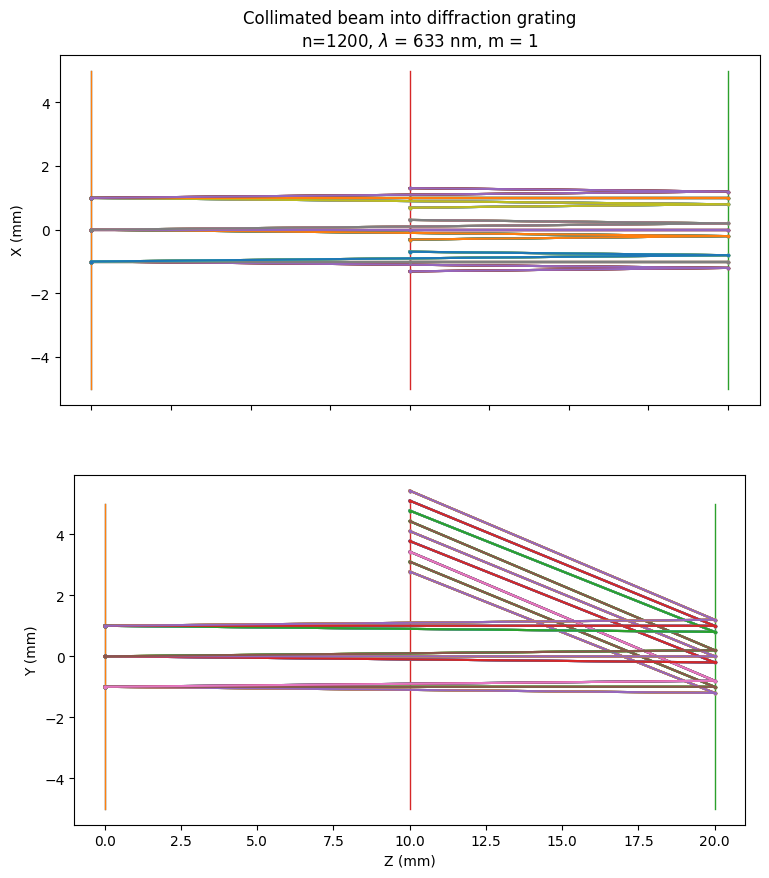

In [39]:
def test5():

    surface_list = [
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "plane grating",
            "dist": -10,
            "m": 1,
            "d": 1 / 600,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": -20, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.01, 0.01, 3)
    field_points = [[x, y, 0] for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([x, y, 1])) for x in lsp for y in lsp]
    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title(
        """Collimated beam into diffraction grating
    n=1200, $\lambda$ = 633 nm, m = 1"""
    )


if run_tests: test5()

### Coordinate breaks
The coordinate break tests are just quick visual checks that the programs are working.

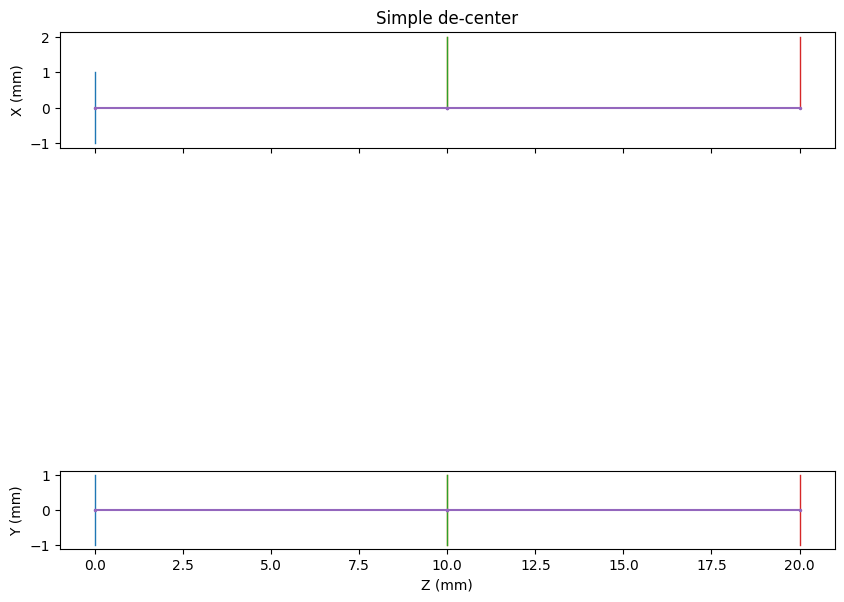

In [40]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "shift", "delta": np.array((1, 0, 0)), "dist": 0, "draw_radius": 1},
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
    ]

    geometry = build_geometry(surface_list)
    field_points = [np.array([0, 0, 0])]
    pupil_points = [np.array([0, 0, 1])]
    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Simple de-center")

if run_tests: test6()

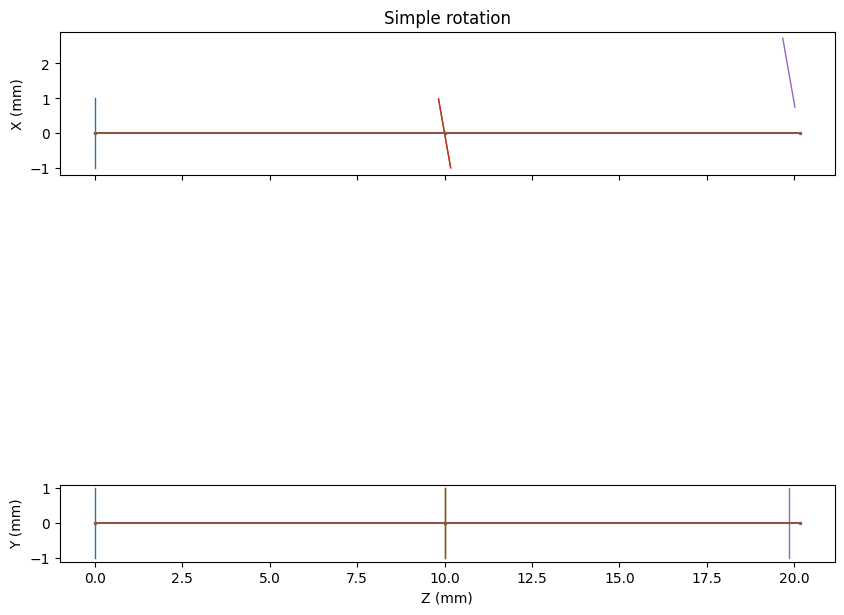

In [41]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 0, "draw_radius": 0},
        {
            "surf": "rotate",
            "axis": np.array((0, 1, 0)),
            "degrees": 10,
            "dist": 0,
            "draw_radius": 1,
        },
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 0, "draw_radius": 1},
    ]

    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    field_points = [np.array([0, 0, 0])]
    pupil_points = [np.array([0, 0, 1])]
    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Simple rotation")

if run_tests: test6()

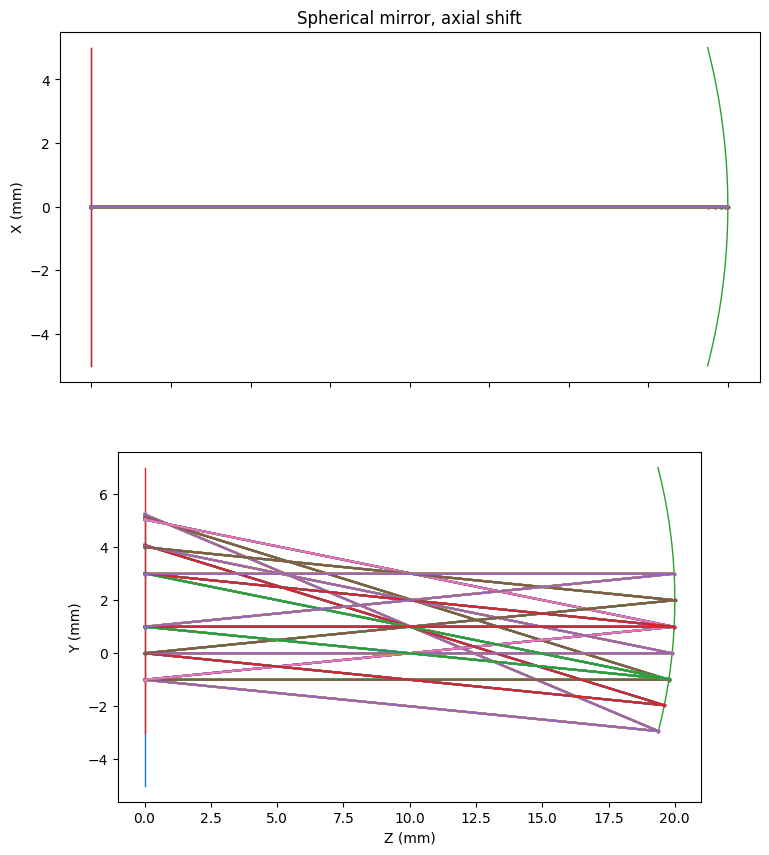

In [42]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {"surf": "shift", "delta": np.array([0, 2, 0]), "dist": 0, "draw_radius": 0},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 20,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.1, 0.1, 3)

    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Spherical mirror, axial shift")
    
if run_tests: test6()

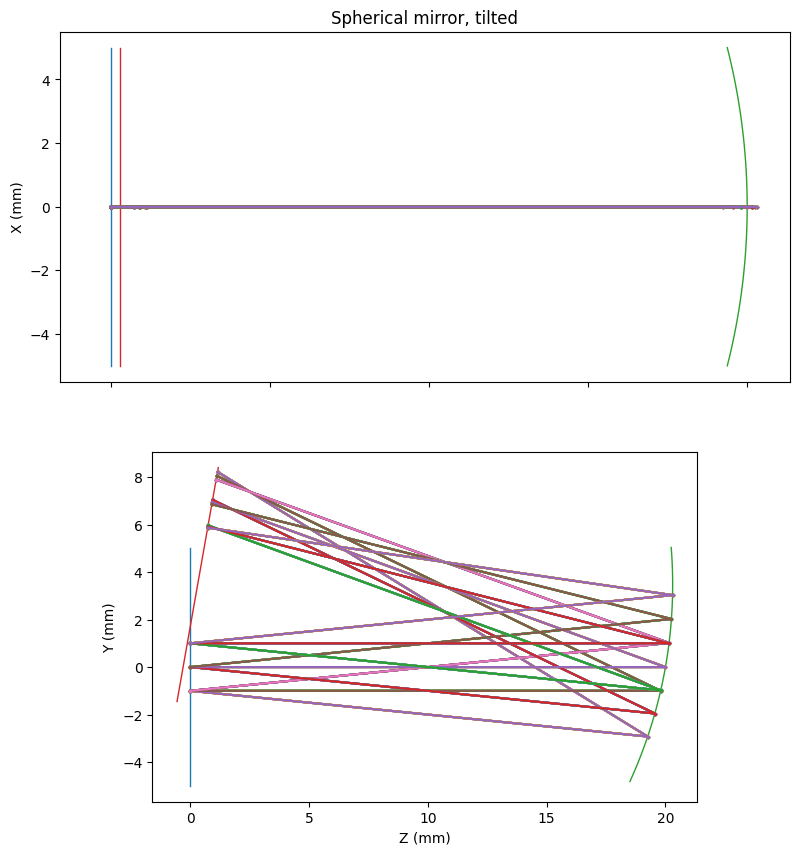

In [43]:
def test7():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "rotate",
            "axis": np.array([1, 0, 0]),
            "degrees": 10,
            "dist": 0,
            "draw_radius": 0,
        },
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 20,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]

    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.1, 0.1, 3)
    
    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_table = ray_table_from_fields_vectors(geometry, field_points, pupil_points)
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)
    axd["axs"][0].set_title("Spherical mirror, tilted")

if run_tests: test7()

In [1]:
def test8():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "cylindrical",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "cylindrical",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-2, 2, 3)
    lsp = np.linspace(-2, 2, 3)
    fieldPoints = np.array([[x, y, 0] for x in lsf for y in lsf])
    pupilPoints = np.array([[x, y, 20] for x in lsp for y in lsp])
    
    ray_table = ray_table_from_fields_points(geometry, fieldPoints, pupilPoints)
    
    ray_properties = default_ray_properties(ray_table)
    propagate_ray(ray_table, ray_properties, geometry)
    axd = new_plot_xy(figsize = (10, 10))
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_table, ray_properties)
    axd["axs"][0].set_title("Multiple rays through basic lens")

if run_tests: test8()

NameError: name 'run_tests' is not defined